In [1]:
import os, sys
sys.path.append(r"../")
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

from import_fun import compute_mle_jit

In [2]:
@njit
def Rossler(x, x_tau, t, gam):
    res = np.zeros_like(x)
    # 常数
    alpha = 0.2
    beta = 0.2
    gamma = 9.
    # 输出函数变量
    res[0] = -x[1] - x[2]
    res[1] = x[0] + alpha * x[1]
    res[2] = beta + (x[0] - gamma)*x[2]
    return res

@njit
def jac(x, x_tau, t, gam):
    res = np.zeros((x.shape[0], x.shape[0]))
    # 常数
    alpha = 0.2
    beta = 0.2
    gamma = 9.
    # 输出函数变量
    res[0, 0], res[0, 1], res[0, 2] = 0, -1, -1
    res[1, 0], res[1, 1], res[1, 2] = 1, alpha, 0
    res[2, 0], res[2, 1], res[2, 2] = x[2], 0, x[0] - gamma
    
    df_dx_tau = np.zeros((x.shape[0], x.shape[0]))
    df_dx_tau[0, 0] = 1   # 1 --> 1

    return res, -gam*df_dx_tau

In [3]:
@njit
def lorenz(x, x_tau, t, gam):
    res = np.zeros_like(x)
    # 常数
    SIGMA = 10
    R = 28
    BETA = 2
    # 输出函数变量
    res[0] = SIGMA * (x[1] - x[0])
    res[1] = R * x[0] - x[1] - x[0] * x[2]
    res[2] = x[0] * x[1] - BETA * x[2]
    return res


@njit
def jac1(x, x_tau, t, gam):
    res = np.zeros((x.shape[0], x.shape[0]))
    # 常数
    SIGMA = 10
    R = 28
    BETA = 2
    # 输出函数变量
    res[0, 0], res[0, 1], res[0, 2] = -SIGMA, SIGMA, 0
    res[1, 0], res[1, 1], res[1, 2] = R - x[2], -1, -x[0]
    res[2, 0], res[2, 1], res[2, 2] = x[1], x[0], -BETA

    DH = np.zeros((x.shape[0], x.shape[0]))
    # DH[0, 0] = 1   # 1-->1
    # DH[1, 0] = 1   # 1-->2
    DH[0, 1] = 1  # 2-->1
    # DH[2, 2] = 1  # 3-->3

    return res, -gam*DH

In [4]:
T_init = int(5e4)
T_cal = int(1e6)
t0 = 0.

In [5]:
# gam = 10.  # lam*c
# tau = 0.0
# x0 = np.random.rand(3)
# dt = 0.01
# mle = compute_mle_jit(x0, Rossler, jac, tau, T_init, T_cal, dt, gam)

In [6]:
x0 = np.random.rand(3)
dt = 0.01
gam_list = np.arange(0, 10., 0.1)
tau_list = [0., 0.24, 0.4]

# gam_list = np.arange(0, 30., 0.1)
# tau_list = [0., 0.05]

In [7]:
@njit(parallel=True)
def parallel_msf_mLCE(gam_list, tau_list, x0, f, jac, T_init, T_cal, dt):
    n1 = len(gam_list)
    n2 = len(tau_list)
    mle = np.zeros((n2, n1))
    for i in prange(n1):
        gam = gam_list[i]
        for j in range(n2):
            tau = tau_list[j]
        
            mle[j, i] = compute_mle_jit(x0, f, jac, tau, T_init, T_cal, dt, gam)

    return mle

In [8]:
mles = parallel_msf_mLCE(gam_list, tau_list, x0, Rossler, jac, T_init, T_cal, dt)
# mles = parallel_msf_mLCE(gam_list, tau_list, x0, lorenz, jac1, T_init, T_cal, dt)

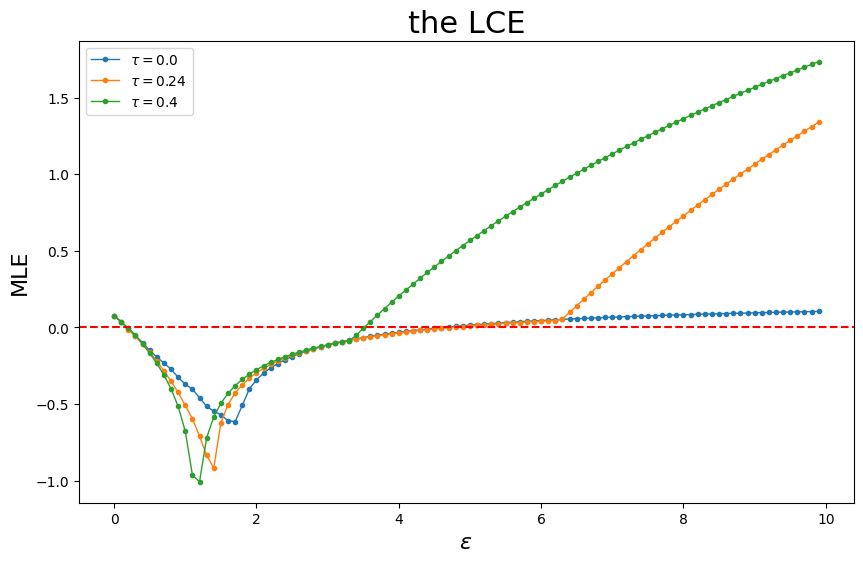

In [9]:
# %matplotlib widget
# Plot of LCE_list
plt.figure(figsize=(10, 6))
for i, tau in enumerate(tau_list): 
    plt.plot(gam_list[:mles.shape[1]], mles[i], '-o', markersize=3, linewidth=1, label=rf"$\tau={tau}$")    # , color="b"
plt.legend()
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel(r"$\varepsilon$ ", fontsize=16)
plt.ylabel("MLE", fontsize=16)
plt.title("the LCE", fontsize=22)
plt.show()